In [1]:
import math
import numpy as np
import scipy
from matplotlib.pyplot import figure, show
import matplotlib as mpl
import matplotlib.pyplot as plt
import illustris_python as il

In [2]:
basePath = "/Users/users/nastase/PROJECT/"

# 1: Selecting a Box and getting rid of particles

In [3]:
dm_pos = il.snapshot.loadSubset(basePath, 135, 'dm', ['Coordinates'])

In [32]:
# This randomly selects 1/128 of the initial data

N_el = len(dm_pos)
random = np.random.uniform(0,1,N_el)
mask = random < 1/20

In [33]:
dm_pos_small = dm_pos[mask]

In [34]:
dm_pos_small

array([[  860.6301, 26322.53  , 18284.877 ],
       [  859.7182, 26319.043 , 18280.166 ],
       [  857.1922, 26325.244 , 18288.926 ],
       ...,
       [63034.668 , 31973.18  , 63962.324 ],
       [59066.92  , 45572.824 , 27697.115 ],
       [60536.855 , 49059.383 , 56893.633 ]], dtype=float32)

Text(0, 0.5, 'y [ckpc/h]')

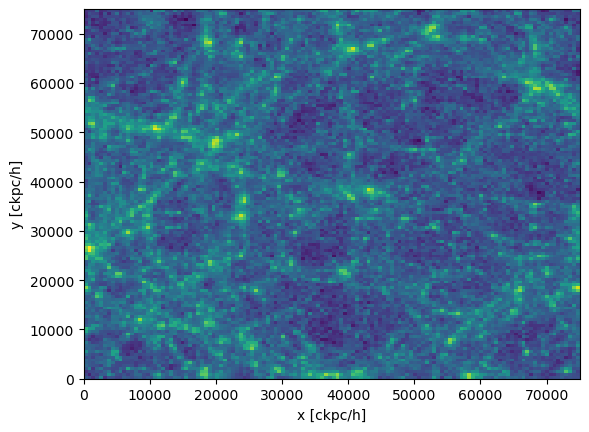

In [22]:
plt.hist2d(dm_pos_small[:,0], dm_pos_small[:,1], norm=mpl.colors.LogNorm(), bins=128);
plt.xlim([0,75000])
plt.ylim([0,75000])
plt.xlabel('x [ckpc/h]')
plt.ylabel('y [ckpc/h]')

Text(0, 0.5, 'y [ckpc/h]')

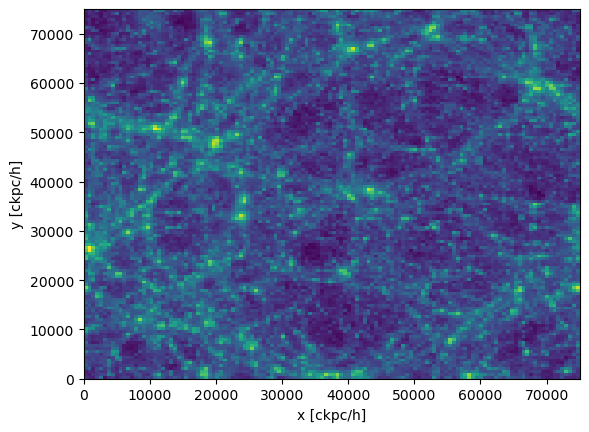

In [30]:
plt.hist2d(dm_pos[:,0], dm_pos[:,1], norm=mpl.colors.LogNorm(), bins=128);
plt.xlim([0,75000])
plt.ylim([0,75000])
plt.xlabel('x [ckpc/h]')
plt.ylabel('y [ckpc/h]')

In [35]:
points = dm_pos_small

In [36]:
m = np.ones(len(points))

# 2: DTFE

In [9]:
#Load the numpy and scipy libraries
from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union

@numba.jit(nopython=True, nogil=True)
def tetrahedron_volume(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]],
                                       points[sim[3]] - points[sim[0]])))) / 6

@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = tetrahedron_volume(sim, pts)
        for index in sim:
            rho[index] += vol
    return (3 + 1) * m / rho

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts: float64[:,:], simps: float64[:,:], rho: float64[:],
                      v: float64[:,:]) -> tuple[np.ndarray, np.ndarray]:
    N = len(simps)
    Drho = np.zeros((N, 3), dtype='float64')
    Dv   = np.zeros((N, 3, 3), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2, p3] = pts[s]
        [r0, r1, r2, r3] = rho[s]
        [v0, v1, v2, v3] = v[s]

        Ainv: float64[:,:] = np.linalg.inv(np.stack((p1 - p0, p2 - p0, p3 - p0)))
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0, r3 - r0])
        Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0, v3 - v0))
    return (Drho, Dv)

@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result

#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, velocities, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho, self.Dv = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho, self.velocities)

    #The interpolations
    def density(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])

    def v(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.velocities[pointIndex], self.Dv[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])
    
    def gradV(self, x, y, z):
        return self.Dv[self.delaunay.find_simplex(np.c_[x, y, z])]

    def theta(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        return (self.Dv[simplexIndex][...,0,0] + 
                self.Dv[simplexIndex][...,1,1] + 
                self.Dv[simplexIndex][...,2,2])

    def sigma(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        Dv = self.Dv[simplexIndex]
        theta = Dv[...,0,0] + Dv[...,1,1] + Dv[...,2,2]
        return np.array([[Dv[...,0,0] - theta / 3       , (Dv[...,0,1] + Dv[...,1,0]) / 2, (Dv[...,0,2] + Dv[...,2,0]) / 2],
                        [(Dv[...,1,0] + Dv[...,0,1]) / 2,  Dv[...,1,1] - theta / 3       , (Dv[...,1,2] + Dv[...,2,1]) / 2],
                        [(Dv[...,2,0] + Dv[...,0,2]) / 2, (Dv[...,2,1] + Dv[...,1,2]) / 2,  Dv[...,2,2] - theta / 3       ]]) 
    
    def omega(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        Dv = self.Dv[simplexIndex]
        zeros = np.zeros(len(simplexIndex))
        return (np.array([[zeros, (Dv[...,0,1] - Dv[...,1,0]) / 2, (Dv[...,0,2] - Dv[...,2,0]) / 2],
                          [(Dv[...,1,0] - Dv[...,0,1]) / 2, zeros, (Dv[...,1,2] - Dv[...,2,1]) / 2],
                          [(Dv[...,2,0] - Dv[...,0,2]) / 2, (Dv[...,2,1] - Dv[...,1,2]) / 2, zeros]])) 

In [10]:
def power(k, gamma):
    return k**gamma

def GRF(L, gamma, sigma):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    k2 = kx**2 + ky**2 + kz**2
    smooth_kernel = np.exp(- sigma ** 2 * k2 / 2)
    grf = np.fft.ifftn(
        np.sqrt(power(k2, gamma)) * 
                smooth_kernel * 
                np.fft.fftn(np.random.normal(0, 1, (L, L, L)))).real
    return grf / np.std(grf)

def gradient(data):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    
    datax = -np.fft.ifftn(kx * np.fft.fftn(data)).imag
    datay = -np.fft.ifftn(ky * np.fft.fftn(data)).imag
    dataz = -np.fft.ifftn(kz * np.fft.fftn(data)).imag
    
    return np.transpose(np.array([datax, datay, dataz]),(1,2,3,0))

def Zeldovich(grf, D):
    velocities = gradient(grf)
    X, Y, Z = np.meshgrid(np.arange(L), np.arange(L), np.arange(L))
    points = np.transpose(np.array([X, Y, Z]), (1,2,3,0)) + D * velocities
    return (points.reshape(L**3, 3), velocities.reshape(L**3, 3))

In [37]:
# L = 100
# step = 100
# sigma = 8
# gamma = 1
# n = int(L/step)

grf = GRF(100, gamma, sigma)
points_vel, velocities = Zeldovich(grf, 20)

In [38]:
normx = points[:,0] - np.min(points[:,0])
normy = points[:,1] - np.min(points[:,1])
normz = points[:,2] - np.min(points[:,2])

points_norm = np.transpose(np.array([normx,normy,normz]))

## diverse masks and their respective runtimes:

- DTFE

    - 1/75: 1min 25s

    - 1/20: 5min 52s
    
- DTFE.density
    
    - 1/75:
    
    - 1/20: 13.1 s (n = 256),  55.1 s (n = 512)

In [39]:
%%time
dtfe = DTFE(points_norm, velocities, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 5min 34s, sys: 17.5 s, total: 5min 52s
Wall time: 5min 52s


In [14]:
import matplotlib.pyplot as plt
def densPlot(data, imageSize):
    X = np.arange(0, data.shape[0])
    Y = np.arange(0, data.shape[1])
    X, Y = np.meshgrid(X, Y)

    plt.figure(figsize=(imageSize, imageSize))
    plt.pcolormesh(X, Y, data, shading='auto')
    plt.axis("equal")
    plt.show()

In [48]:
n = int(np.sqrt(len(dm_pos_small)))

In [49]:
n

2170

In [58]:
print(np.sqrt(20e6))

4472.13595499958


In [59]:
two_powers = []
for i in range(0, 14):

    two_powers.append(2**i)

In [60]:
two_powers

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [44]:
n = 512
L = 75000

X, Y, Z = np.meshgrid(np.linspace(0.01*L, 0.99*L, n),   
                   np.linspace(0.01*L, 0.99*L, n),
                  np.linspace(0.01*L, 0.99*L, n))


In [45]:
%%time
d = dtfe.density(X.flat, Y.flat, Z.flat).reshape((n,n,n))
dens = d[1:n-1, 1:n-1, 1:n-1]

CPU times: user 44 s, sys: 10.9 s, total: 54.9 s
Wall time: 55.1 s


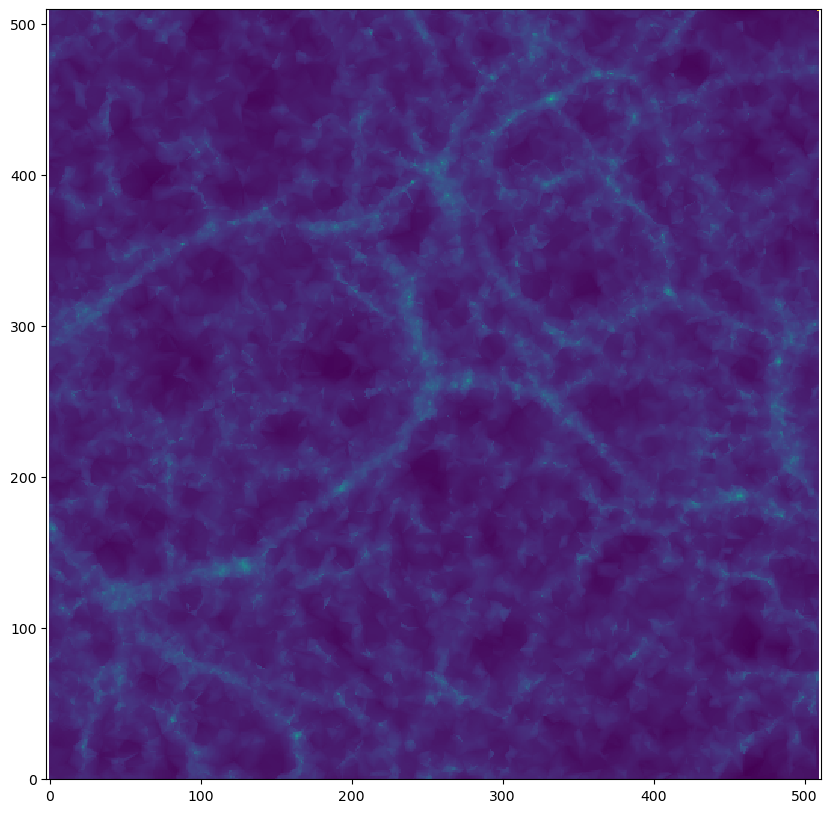

In [46]:
densPlot(np.log(dens[-1]), 10)

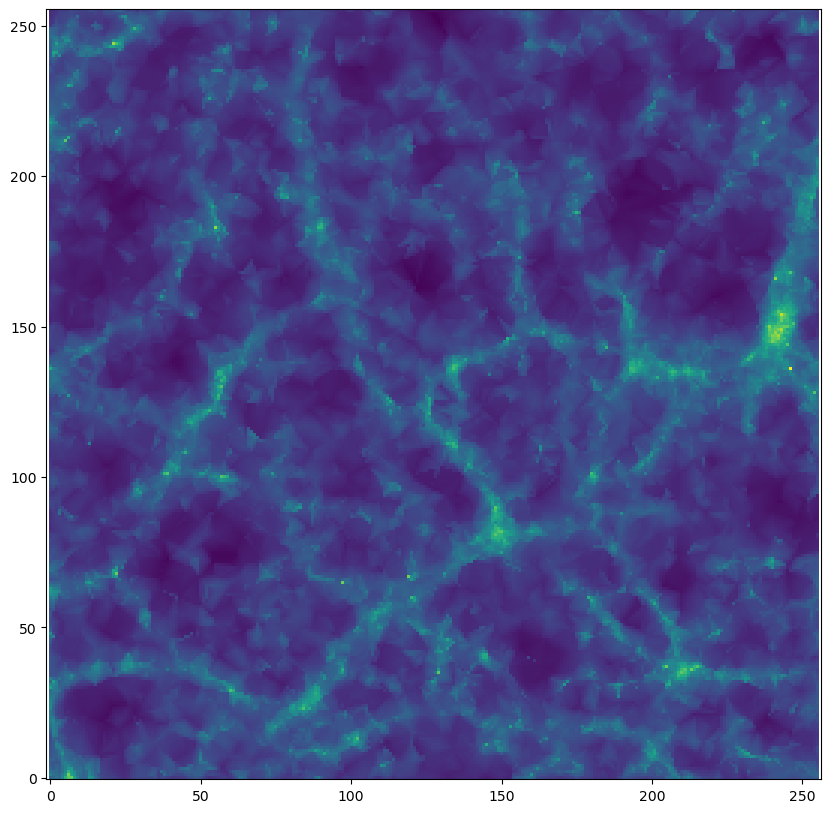

In [31]:
densPlot(np.log(dens[int(n/2)]), 10)